# ODESolver vs LSTM

In [1]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

import seaborn as sns
plt.style.use("seaborn")
sns.set_style("white")


import matplotlib.colors as mcolors
import cv2

cuda


/tmp/ipykernel_544/193949135.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
# Load the data   
def preprocess(data):
    a = data
    m, std = np.mean(a[:, :, 0]), np.std(a[:, :, 0])
    a[:, :, 0] = (a[:, :, 0] - m) / std 
    print(np.min(a[:, :, 0]), np.max(a[:, :, 0]))
    m, std = np.mean(a[:, :, 1]), np.std(a[:, :, 1])
    a[:, :, 1] = (a[:, :, 1] - m) / std 
    m, std = np.mean(a[:, :, 2]), np.std(a[:, :, 2])
    a[:, :, 2] = (a[:, :, 2] - m) / std 
    m, std = np.mean(a[:, :, 3]), np.std(a[:, :, 3])
    a[:, :, 3] = (a[:, :, 3] - m) / std 
    return a


with open('X_400_109_ori.pickle', 'rb') as handle:
    data = pickle.load(handle)

# Define the training and test sets
train_size = int(data.shape[0] * 0.8)
test_data = preprocess(data[train_size:])
print(test_data.shape)

s = 1#np.random.randint(len(test_loader))
cell = 12*24+20

-1.0850763396420926 3.24444338332082
(10961, 576, 4)


-1.0990786098543488 3.2455547943257375


/tmp/ipykernel_544/2498511784.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


[]

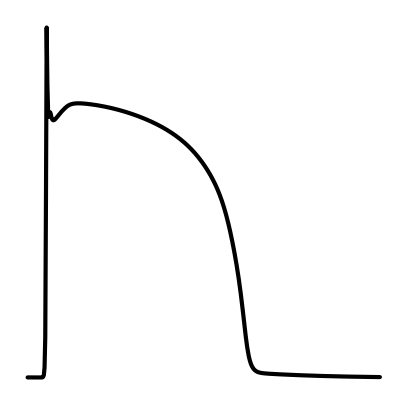

In [3]:
with open('X_400_109_ori.pickle', 'rb') as handle:
    data = preprocess(pickle.load(handle))


plt.style.use("seaborn")
sns.set_style("white")
sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '--'})

plt.figure(figsize=(5, 5))
plt.plot(range(500), data[:500, 2, 0], color="black", linewidth=3)
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

-1.0990786098543488 3.2455547943257375


/tmp/ipykernel_544/3616187096.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


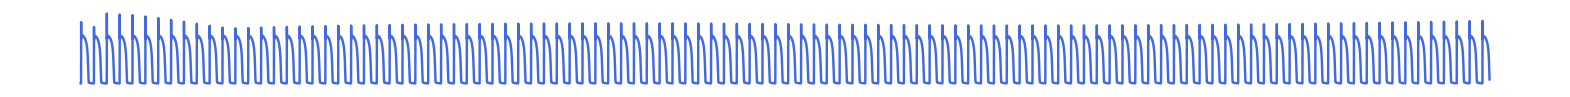

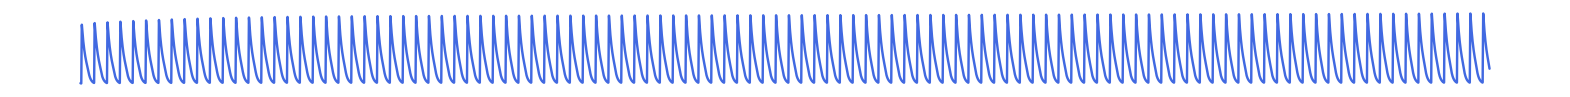

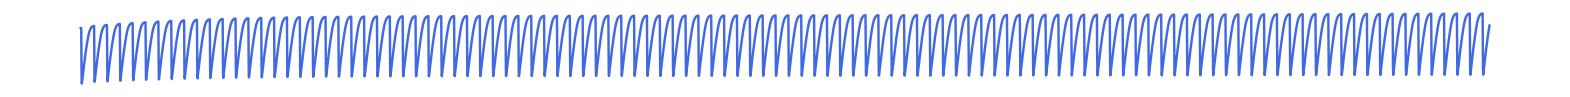

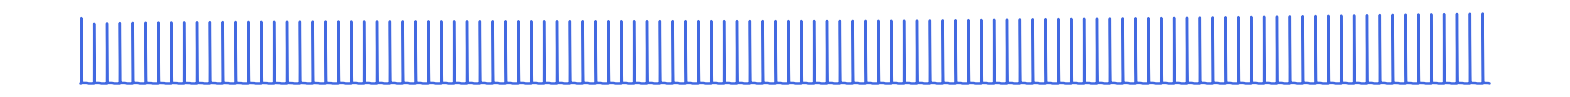

In [4]:
with open('X_400_109_ori.pickle', 'rb') as handle:
    data = preprocess(pickle.load(handle))


plt.style.use("seaborn")
sns.set_style("white")
sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '--'})

plt.figure(figsize=(20, 1))
plt.plot(range(data.shape[0]), data[:, 2, 0], color="royalblue")
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('fig_x_Vm.png', dpi=500)

plt.figure(figsize=(20, 1))
plt.plot(range(data.shape[0]), data[:, 2, 1], color="royalblue")
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('fig_x_Cai.png', dpi=500)

plt.figure(figsize=(20, 1))
plt.plot(range(data.shape[0]), data[:, 2, 2], color="royalblue")
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('fig_x_CASR.png', dpi=500)

plt.figure(figsize=(20, 1))
plt.plot(range(data.shape[0]), data[:, 2, 3], color="royalblue")
ax = plt.gca()
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('fig_x_Cass.png', dpi=500)

In [5]:
import time

start_time = time.time()

# load and prediction ODE 
nindicators = 4
ncells = 576
latent_dim = 50
nhidden = 50
rnn_nhidden = 20
obs_dim = ncells * nindicators
batch_size = 16
seq_len = 1000
noise_std = 0.005
cycle_len = 500


def remap(x, out_min, out_max):
    in_min, in_max = np.min(x), np.max(x)
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min


class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)   # outputs latent state of dim 4
        self.nfe = 0

    def forward(self, t, x): # Note that forward pass has time t as input as well, as compared to RNN where the argument would be no. of neurons in hidden layers!
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out
    
class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2) # Note that we are outputing twice the size of latent dim, this will go in as qz0_mean and qz0_logvar ... see training loop

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self, batch_size=None):
        if batch_size is None:
            return torch.zeros(self.nbatch, self.nhidden)
        else:
            return torch.zeros(batch_size, self.nhidden)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    
PATH = "0329/lstm_ar_usingbench2-2-2355-VAEnonoise.pt"

func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)

checkpoint = torch.load(PATH)
func.load_state_dict(checkpoint['func_dict'])
rec.load_state_dict(checkpoint['rec_dict'])
dec.load_state_dict(checkpoint['dec_dict'])

func.eval()
rec.eval()
dec.eval()


# Test the model
future_n_cycle = 12
with torch.no_grad():
    h = torch.zeros(1, rnn_nhidden).to(device)
    inpt_data = test_data[s:s+cycle_len*2].copy()
    inpt_data[:, :, 0] = remap(inpt_data[:, :, 0], -1, 1)
    inpt_data[:, :, 1] = remap(inpt_data[:, :, 1], -1, 1)
    inpt_data[:, :, 2] = remap(inpt_data[:, :, 2], -1, 1)
    inpt_data[:, :, 3] = remap(inpt_data[:, :, 3], -1, 1)
    inpts = torch.from_numpy(inpt_data).float().unsqueeze(0).to(device)
    print(inpts.size())

    # warm-up
    for t in reversed(range(seq_len)):
        obs = inpts[:, t, :]
        obs = obs.view(1, ncells*nindicators)
        out, h = rec.forward(obs, h) # init forward pass to create batch_y0 for training

    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    epsilon = torch.randn(qz0_mean.size()).to(device)
    z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

    future_ts = torch.from_numpy(np.linspace(0, future_n_cycle/2, num=cycle_len*future_n_cycle)).to(device)

    # forward in time and solve ode for reconstructions
    pred_z = odeint(func, z0, future_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)  #decoder
    pred_x = pred_x.view(1, -1, ncells, nindicators)
    print(pred_x.size())
    pred_x = pred_x.cpu().detach().numpy()
    
end_time = time.time()

total_time = end_time - start_time
print(f"Total running time: {total_time} seconds.")

torch.Size([1, 1000, 576, 4])
torch.Size([1, 6000, 576, 4])
Total running time: 8.056706428527832 seconds.


In [6]:
import time

start_time = time.time()

# define the hyperparameters
n_cells = 576
n_indicators = 4
input_size = n_cells, n_indicators
hidden_size = 64
learning_rate = 0.001
num_epochs = 3
batch_size = 16
seq_len = 1000
num_layers = 2
cycle_len = 500


# define the autoregressive forecasting model
class LSTM(nn.Module):
    def __init__(self, num_input_features, hidden_layer_size, num_layers):
        super().__init__()
        input_size = num_input_features[0] * num_input_features[1]
        
        self.num_layer = num_layers
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_layer_size, input_size)
        self.hidden_cell = None

    def forward(self, x):
        batch_size, seq_len, height, width = x.size()
        x = x.view(batch_size, seq_len, height*width)
        lstm_out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        preds = []
        for t in range(seq_len):
            pred = self.fc(lstm_out[:, t, :])
            pred = pred.view(batch_size, 1, height, width)
            preds.append(pred)
        
        return torch.cat(preds, axis=1)
    
model = LSTM(input_size, hidden_size, num_layers)

# path = f"0329/lstm_ar_0329-minloss-0-1118.pt"
# path = f"0407/lstm_ar-minloss-0-1923.pt"
path = "0410/lstm_ar-minloss-2-1802.pt"
model.load_state_dict(torch.load(path))
model = model.to(device)

# evaluate model:
model.eval()

# Test the model
# future = 6000
# warm_up = 500
# with torch.no_grad():
#     inputs = torch.from_numpy(test_data).float().to(device)
#     inputs = inputs.unsqueeze(0)

#     preds = []
# #     inpt = inputs[:, s-warm_up-1: s-1, :, :]
#     print(inpt.size())
#     model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size).to(device),
#                     torch.zeros(num_layers, 1, model.hidden_layer_size).to(device))
#     pred_outputs = model(inpt)
#     inpt = pred_outputs[:, -1, :, :].unsqueeze(1)

#     for i in range(future):
#         output = model(inpt)
#         preds.append(output)
#         inpt = output
#     preds = torch.cat(preds, axis=1)
#     Vm = np.array(preds.cpu().detach().numpy())  # 1, future, 576, 4

def proposed_prediction(start):  # start > warm_up
    # Test the model
    future = 6000
    warm_up = cycle_len
    with torch.no_grad():
        inputs = torch.from_numpy(test_data).float().to(device)
        inputs = inputs.unsqueeze(0)

        preds = []
#         inpt = inputs[:, start-warm_up-1: start-1, :, :]
        inpt = inputs[:, start-1: start+warm_up-1, :, :]
        model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size).to(device),
                        torch.zeros(num_layers, 1, model.hidden_layer_size).to(device))
        pred_outputs = model(inpt)
        inpt = inputs[:, start-1, :, :].unsqueeze(1)
#         inpt = pred_outputs[:, -1, :, :].unsqueeze(1)
#         inpt = pred_outputs[:, 0, :, :].unsqueeze(1)

        for i in range(future):
            output = model(inpt)
            preds.append(output)
            inpt = output
        preds = torch.cat(preds, axis=1)
        Vm = np.array(preds.cpu().detach().numpy())  # 1, future, 576, 4
    return Vm
Vm = proposed_prediction(s)
end_time = time.time()

total_time = end_time - start_time
print(f"Total running time: {total_time} seconds.")

Total running time: 1.3943421840667725 seconds.


In [7]:
error_proposed = 0.
error_benchmark = 0.
error = 0.

for i in range(ncells):
    for j in range(4):
        pred_proposed = remap(Vm[0, :, i, j], -1, 1)
        pred_benchmark = remap(pred_x[0, :, i, j], -1, 1)
        truee = remap(test_data[s:s+6000, i, j], -1, 1)
        error_proposed += sum((pred_proposed - truee)**2)
        error_benchmark += sum((pred_benchmark - truee)**2)

print(np.mean(error_proposed), np.mean(error_benchmark))

856727.08236748 11964778.573584622


In [8]:
for i in range(4):
    a = remap(Vm[0, :500, :, i], -1, 1)
    b = remap(pred_x[0, :500, :, i], -1, 1)
    c = remap(preprocess(test_data)[s:s+500, :, i], -1, 1)
    print(i, a.shape, b.shape, c.shape)
    print(np.mean((a-c)**2), np.mean((b-c)**2))

-1.0850763396420926 3.2444433833208217
0 (500, 576) (500, 576) (500, 576)
0.019635310070777963 0.6268419017541236
-1.0850763396420926 3.2444433833208217
1 (500, 576) (500, 576) (500, 576)
0.003200600557192473 0.43957037264929993
-1.0850763396420926 3.2444433833208217
2 (500, 576) (500, 576) (500, 576)
0.006225214129363236 0.3130721272328537
-1.0850763396420926 3.2444433833208217
3 (500, 576) (500, 576) (500, 576)
0.017419651927117405 0.6902230648978173


-1.0850763396420926 3.2444433833208217


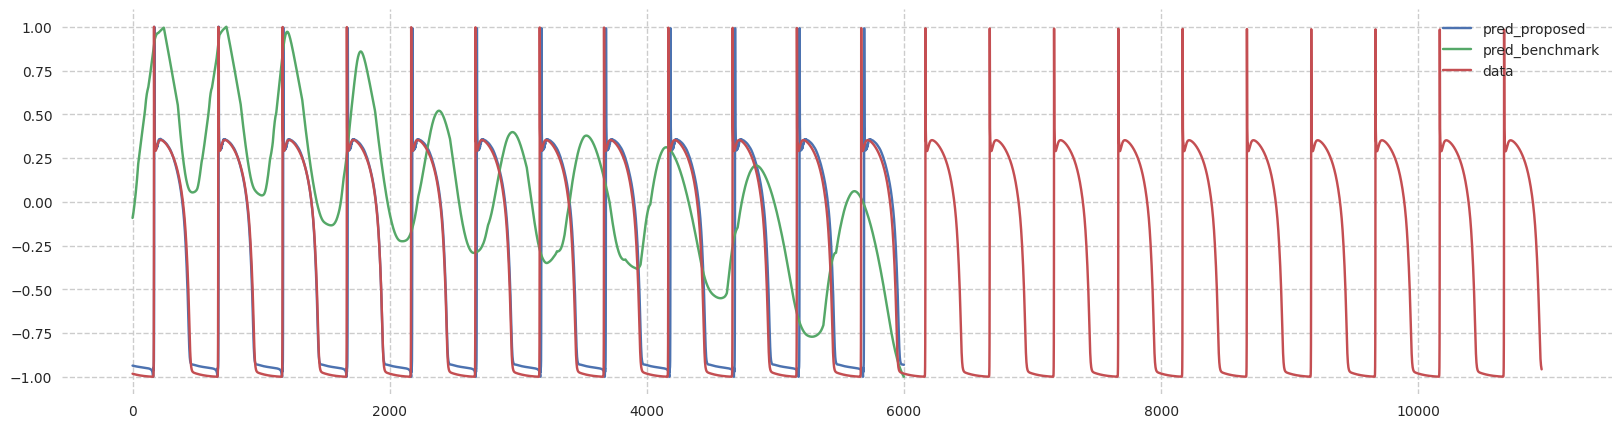

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(Vm.shape[1]), remap(Vm[0, :, cell, 0], -1, 1), label="pred_proposed")
plt.plot(range(pred_x.shape[1]), remap(pred_x[0, :, cell, 0], -1, 1), label="pred_benchmark")
# plt.plot(range(data.shape[0]), remap(data[:, cell, 0], -1, 1), label="data")
plt.plot(range(test_data.shape[0]-s), remap(preprocess(test_data)[s:, cell, 0], -1, 1), label="data")
plt.legend()
plt.show()

         

# Figures

### 1. 1or2 cycles


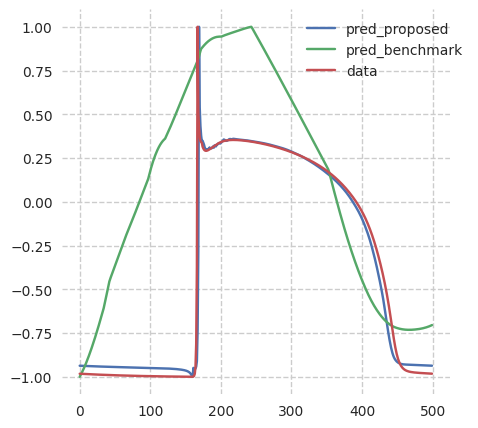

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
x_ax = range(500)
plt.plot(x_ax, remap(Vm[0, :cycle_len, cell, 0], -1, 1), label="pred_proposed")
plt.plot(x_ax, remap(pred_x[0, :cycle_len, cell, 0], -1, 1), label="pred_benchmark")
plt.plot(x_ax, remap(test_data[s:s+cycle_len, cell, 0], -1, 1), label="data")
plt.legend(bbox_to_anchor=(0.6, 1))
plt.show()

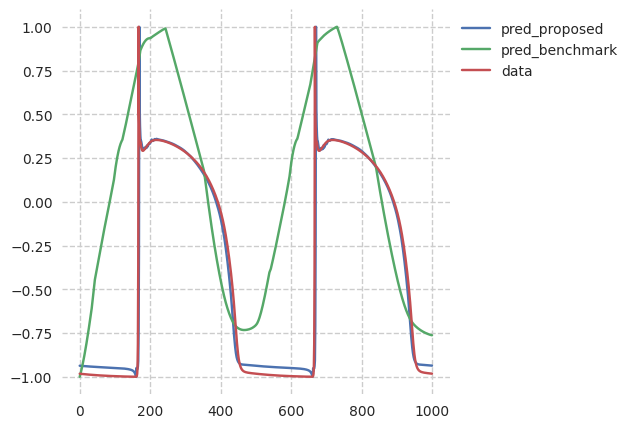

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
x_ax = range(1000)
plt.plot(x_ax, remap(Vm[0, :seq_len, cell, 0], -1, 1), label="pred_proposed")
plt.plot(x_ax, remap(pred_x[0, :seq_len, cell, 0], -1, 1), label="pred_benchmark")
plt.plot(x_ax, remap(test_data[s:s+seq_len, cell, 0], -1, 1), label="data")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()


/tmp/ipykernel_544/2239698022.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


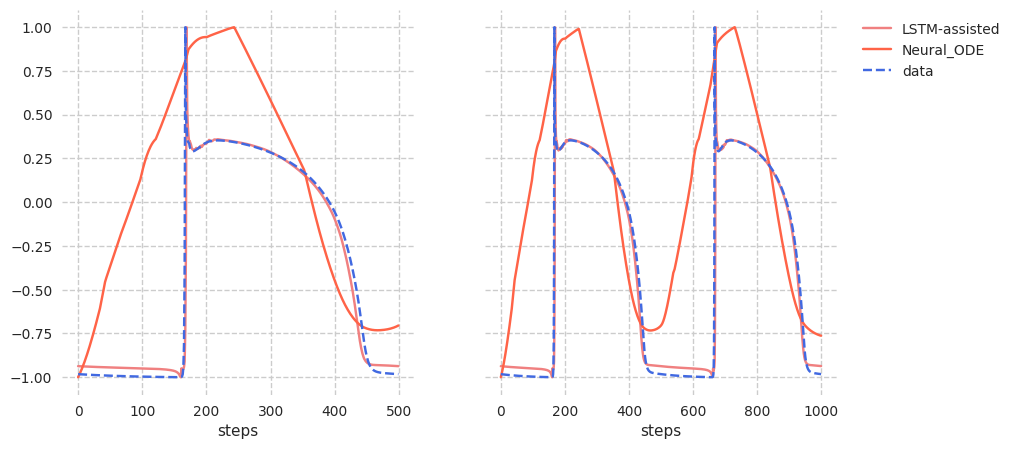

In [12]:
plt.style.use("seaborn")
sns.set_style("white")
sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '--'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
x_ax = range(500)
axs[0].plot(x_ax, remap(Vm[0, :cycle_len, cell, 0], -1, 1), label="LSTM-assisted", color="lightcoral")
axs[0].plot(x_ax, remap(pred_x[0, :cycle_len, cell, 0], -1, 1), label="Neural_ODE", color="tomato")
axs[0].plot(x_ax, remap(test_data[s:s+cycle_len, cell, 0], -1, 1), label="data", color="royalblue", linestyle="dashed")
x_ax = range(1000)
axs[1].plot(x_ax, remap(Vm[0, :seq_len, cell, 0], -1, 1), label="LSTM-assisted", color="lightcoral")
axs[1].plot(x_ax, remap(pred_x[0, :seq_len, cell, 0], -1, 1), label="Neural_ODE", color="tomato")
axs[1].plot(x_ax, remap(test_data[s:s+seq_len, cell, 0], -1, 1), label="data", color="royalblue", linestyle="dashed")

for ax in axs.flat:
    ax.set(xlabel='steps')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.legend(bbox_to_anchor=(1.5, 1.))

plt.savefig('fig_simple_cycle.png', dpi=500, bbox_inches='tight')

/tmp/ipykernel_544/88400914.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


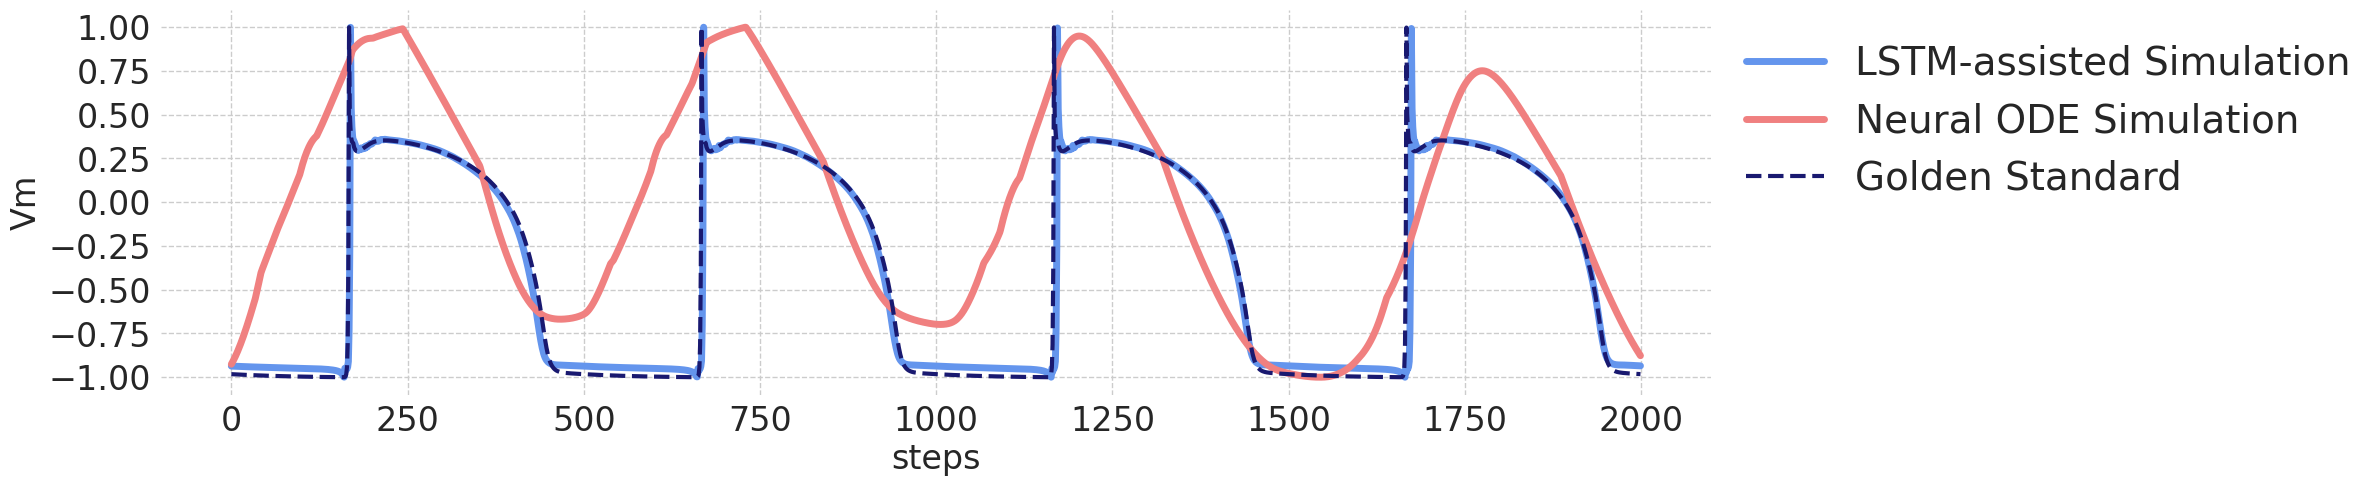

In [13]:
plt.style.use("seaborn")
sns.set_style("white")
sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '--'})

plt.figure(figsize=(20, 5))
length = 2000
x_ax = range(length)
plt.plot(x_ax, remap(Vm[0, :length, cell, 0], -1, 1), label="LSTM-assisted Simulation", color="cornflowerblue", linewidth=5)
plt.plot(x_ax, remap(pred_x[0, :length, cell, 0], -1, 1), label="Neural ODE Simulation", color="lightcoral", linewidth=5) #mediumaquamarine, darkorange, royalblue
plt.plot(x_ax, remap(test_data[s:s+length, cell, 0], -1, 1), label="Golden Standard", color="midnightblue", linestyle="dashed", linewidth=3)
plt.xlabel("steps", fontsize=24)
plt.ylabel("Vm", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

    
plt.legend(bbox_to_anchor=(1., 1.), fontsize=28)
plt.savefig('fig_simple_cycle.png', dpi=500, bbox_inches='tight')

### 2. long-term prediction


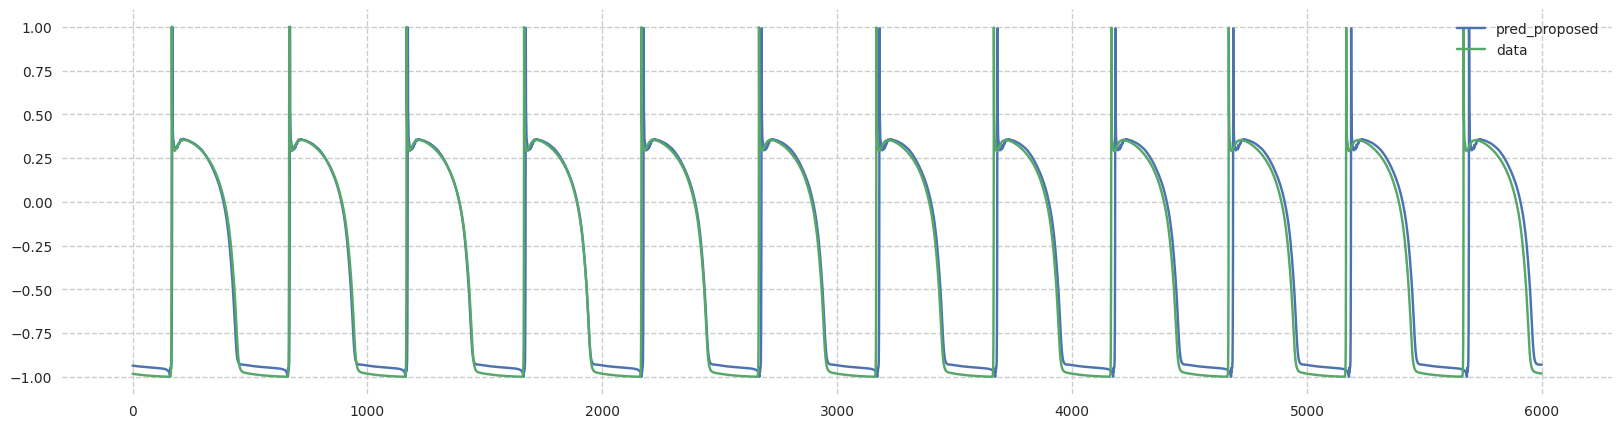

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
x_ax = range(6000)
plt.plot(range(Vm.shape[1]), remap(Vm[0, :, cell, 0], -1, 1), label="pred_proposed")
# plt.plot(range(pred_x.shape[1]), remap(pred_x[0, :, cell, 0], -1, 1), label="pred_benchmark")
# plt.plot(range(data.shape[0]), remap(data[:, cell, 0], -1, 1), label="data")
plt.plot(x_ax, remap(test_data[s:s+6000, cell, 0], -1, 1), label="data")
plt.legend()
plt.show()


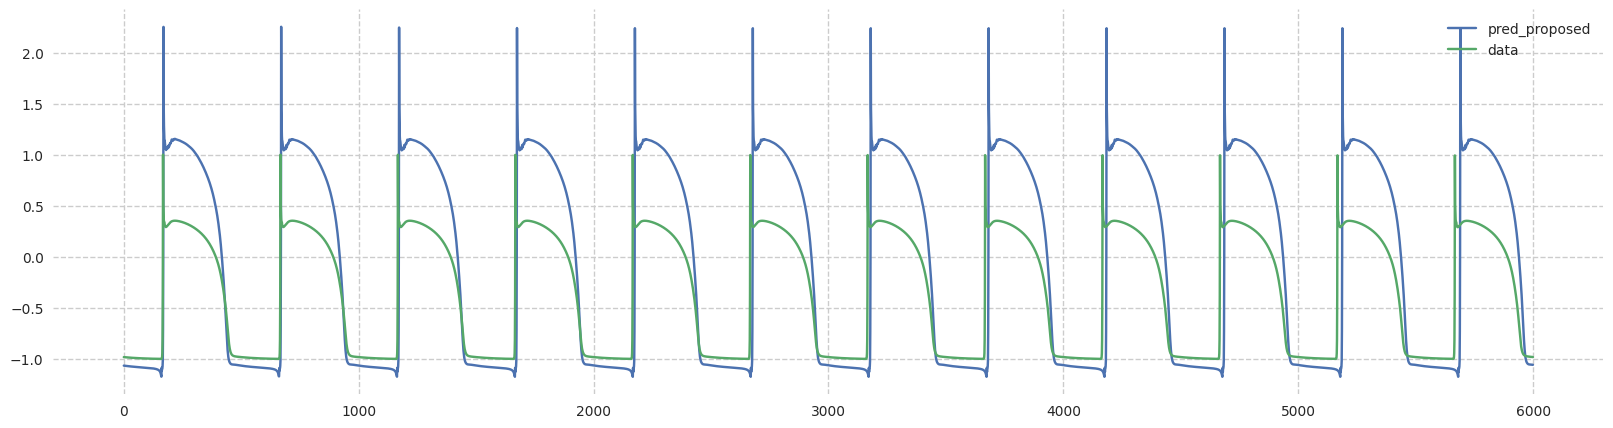

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
x_ax = range(6000)
plt.plot(range(Vm.shape[1]), Vm[0, :, cell, 0], label="pred_proposed")
# plt.plot(range(pred_x.shape[1]), remap(pred_x[0, :, cell, 0], -1, 1), label="pred_benchmark")
# plt.plot(range(data.shape[0]), remap(data[:, cell, 0], -1, 1), label="data")
plt.plot(x_ax, remap(test_data[s:s+6000, cell, 0], -1, 1), label="data")
plt.legend()
plt.show()


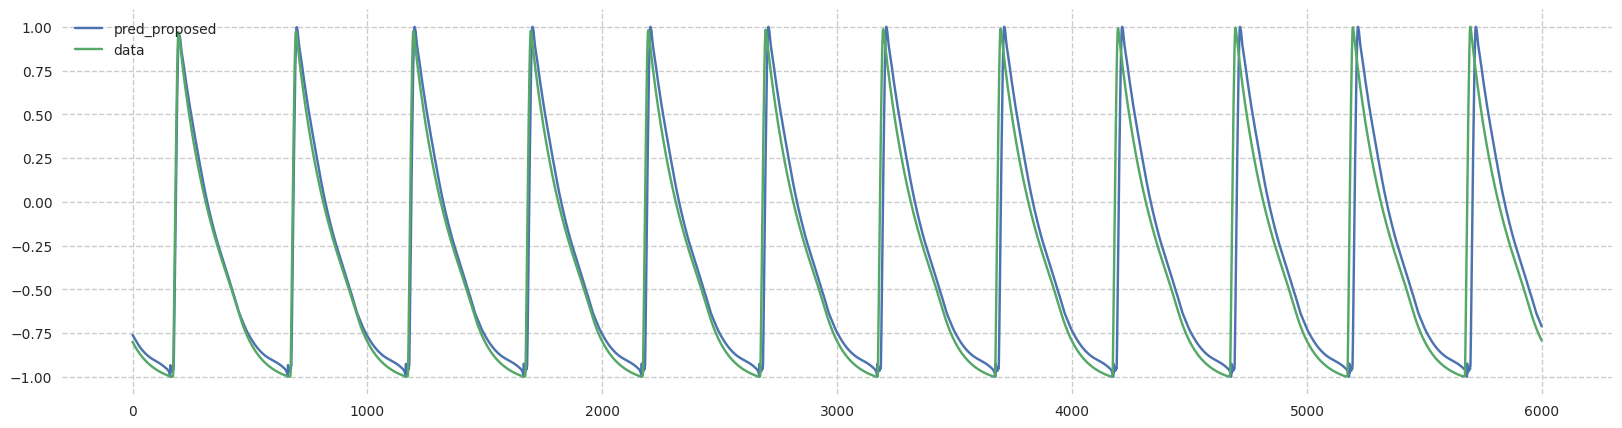

In [17]:
plt.figure(figsize=(20, 5))
x_ax = range(6000)
plt.plot(range(Vm.shape[1]), remap(Vm[0, :, cell, 1], -1, 1), label="pred_proposed")
# plt.plot(range(pred_x.shape[1]), remap(pred_x[0, :, cell, 0], -1, 1), label="pred_benchmark")
# plt.plot(range(data.shape[0]), remap(data[:, cell, 0], -1, 1), label="data")
plt.plot(x_ax, remap(test_data[s:s+6000, cell, 1], -1, 1), label="data")
plt.legend()
plt.show()


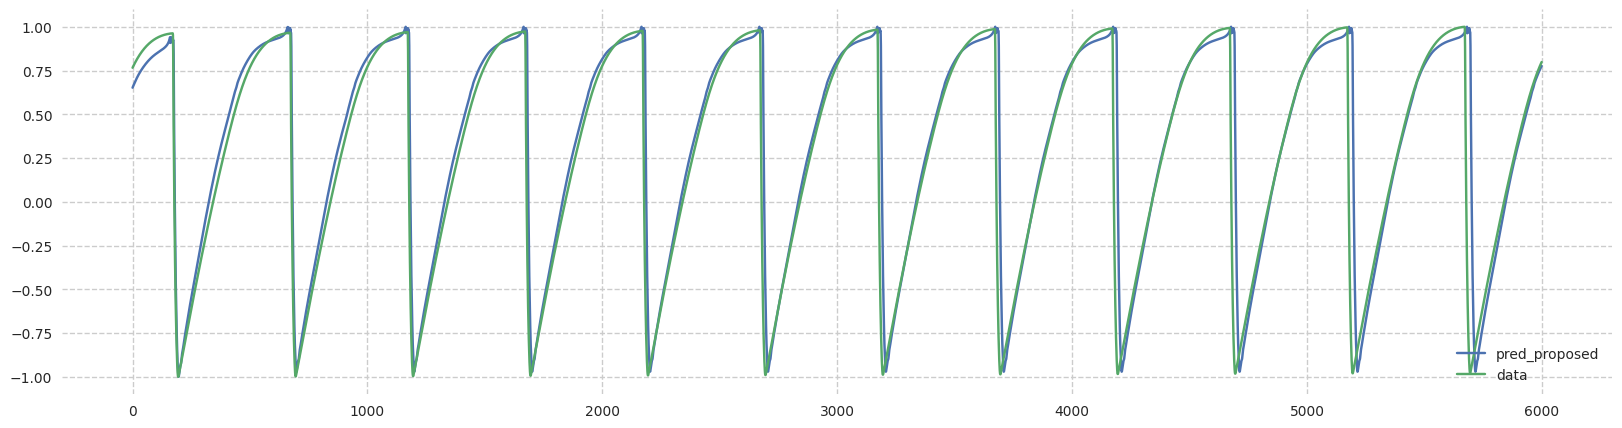

In [18]:
plt.figure(figsize=(20, 5))
x_ax = range(6000)
plt.plot(range(Vm.shape[1]), remap(Vm[0, :, cell, 2], -1, 1), label="pred_proposed")
# plt.plot(range(pred_x.shape[1]), remap(pred_x[0, :, cell, 0], -1, 1), label="pred_benchmark")
# plt.plot(range(data.shape[0]), remap(data[:, cell, 0], -1, 1), label="data")
plt.plot(x_ax, remap(test_data[s:s+6000, cell, 2], -1, 1), label="data")
plt.legend()
plt.show()


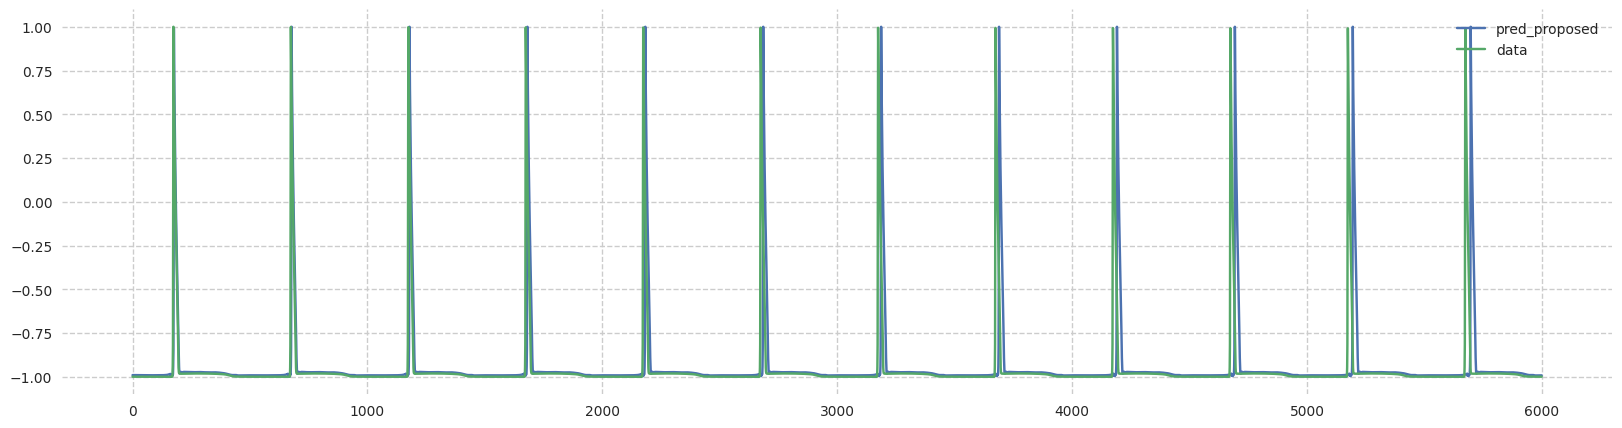

In [19]:
plt.figure(figsize=(20, 5))
x_ax = range(6000)
plt.plot(range(Vm.shape[1]), remap(Vm[0, :, cell, 3], -1, 1), label="pred_proposed")
# plt.plot(range(pred_x.shape[1]), remap(pred_x[0, :, cell, 0], -1, 1), label="pred_benchmark")
# plt.plot(range(data.shape[0]), remap(data[:, cell, 0], -1, 1), label="data")
plt.plot(x_ax, remap(test_data[s:s+6000, cell, 3], -1, 1), label="data")
plt.legend()
plt.show()


/tmp/ipykernel_571/2077545191.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


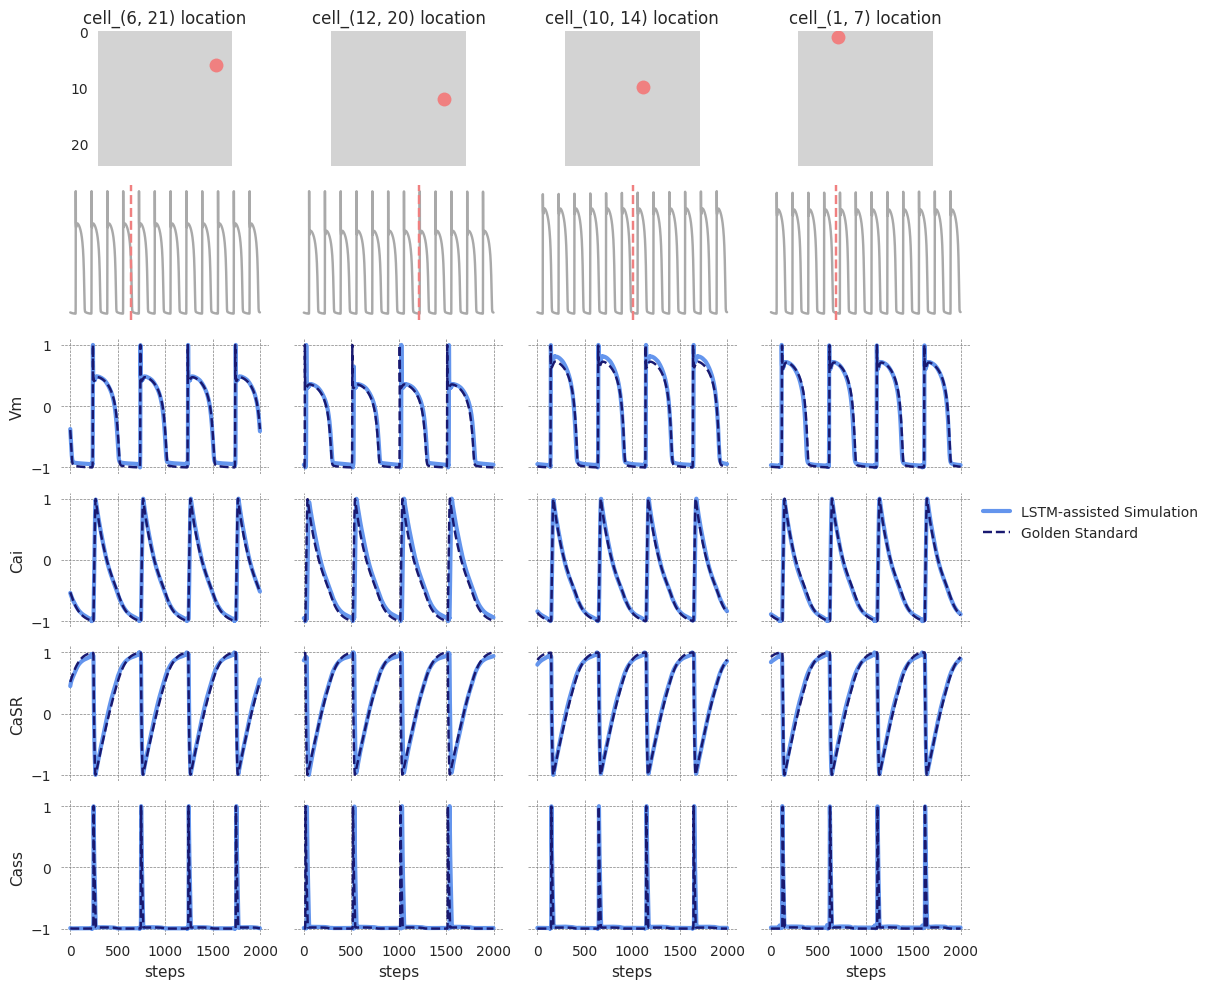

In [120]:
import seaborn as sns
plt.style.use("seaborn")
sns.set_style("white")
# sns.set_style("whitegrid", {'grid.color': '.8', 'grid.linestyle': '--'})


# define the hyperparameters
# n_cells = 576
# n_indicators = 4
# input_size = n_cells, n_indicators
# hidden_size = 64
# learning_rate = 0.001
# num_epochs = 3
# batch_size = 16
# seq_len = 1000
# num_layers = 2
# cycle_len = 500


# # define the autoregressive forecasting model
# class LSTM(nn.Module):
#     def __init__(self, num_input_features, hidden_layer_size, num_layers):
#         super().__init__()
#         input_size = num_input_features[0] * num_input_features[1]
        
#         self.num_layer = num_layers
#         self.input_size = input_size
#         self.hidden_layer_size = hidden_layer_size
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=0.2)
#         self.fc = nn.Linear(hidden_layer_size, input_size)
#         self.hidden_cell = None

#     def forward(self, x):
#         batch_size, seq_len, height, width = x.size()
#         x = x.view(batch_size, seq_len, height*width)
#         lstm_out, self.hidden_cell = self.lstm(x, self.hidden_cell)
#         preds = []
#         for t in range(seq_len):
#             pred = self.fc(lstm_out[:, t, :])
#             pred = pred.view(batch_size, 1, height, width)
#             preds.append(pred)
        
#         return torch.cat(preds, axis=1)
    
# model = LSTM(input_size, hidden_size, num_layers)

# # path = f"0329/lstm_ar_0329-minloss-0-1118.pt"
# path = "0410/lstm_ar-minloss-2-1802.pt"
# model.load_state_dict(torch.load(path))
# model = model.to(device)

# # evaluate model:
# model.eval()


# def proposed_prediction(start):  # start > warm_up
#     # Test the model
#     future = 6000
#     warm_up = cycle_len
#     with torch.no_grad():
#         inputs = torch.from_numpy(test_data).float().to(device)
#         inputs = inputs.unsqueeze(0)

#         preds = []
# #         inpt = inputs[:, start-warm_up-1: start-1, :, :]
#         inpt = inputs[:, start-1: start+warm_up-1, :, :]
#         model.hidden_cell = (torch.zeros(num_layers, 1, model.hidden_layer_size).to(device),
#                         torch.zeros(num_layers, 1, model.hidden_layer_size).to(device))
#         pred_outputs = model(inpt)
#         inpt = inputs[:, start-1, :, :].unsqueeze(1)
# #         inpt = pred_outputs[:, -1, :, :].unsqueeze(1)
# #         inpt = pred_outputs[:, 0, :, :].unsqueeze(1)

#         for i in range(future):
#             output = model(inpt)
#             preds.append(output)
#             inpt = output
#         preds = torch.cat(preds, axis=1)
#         Vm = np.array(preds.cpu().detach().numpy())  # 1, future, 576, 4
#     return Vm


show_data = [(6*24+21, 1935), [12*24+20, 3657], [10*24+14, 3032], [1*24+7, 2067]]

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(10, 10))
vis = 2000

for col in range(4):
#     s = np.random.randint(1, 4000)
#     cell = np.random.randint(ncells)
    s = show_data[col][1]
    cell = show_data[col][0]
    cell_x, cell_y = cell//24, cell%24
    X = proposed_prediction(s)
    for row in range(6):
        if row == 2:
            axs[row, col].set(ylabel='Vm')
#             axs[row, col].set_title(f'cell_({cell_x}, {cell_y}), start_{s}')
        elif row == 3:
            axs[row, col].set(ylabel='Cai')
        elif row == 4:
            axs[row, col].set(ylabel='CaSR')
        elif row == 5:
            axs[row, col].set(ylabel='Cass')
            axs[row, col].set(xlabel='steps')
        elif row == 0:
#             sns.set_style("ticks")
#             grid_size = 24
#             grid = np.ones((grid_size, grid_size))
# #             axs[row, col].set(ylabel='Square')
#             axs[row, col].set_title(f'cell_({cell_x}, {cell_y}) location')
# #             axs[row, col].set_xticks(range(grid_size))
# #             axs[row, col].set_yticks(range(grid_size))
#             axs[row, col].imshow(grid, cmap='gray')
#             axs[row, col].grid(False)
#             axs[row, col].plot(cell_y, cell_x, 'ro', markersize=10)  # 绘制红色的圆圈来标记点 (3, 4)
#             axs[row, col].text(cell_y-1, cell_x+3, f'({cell_x}, {cell_y})', color='white', fontsize=10, ha='center', va='center')  # 在点 (3, 4) 处显示坐标
            
            # version2
            axs[row, col].set_title(f'cell_({cell_x}, {cell_y}) location')
            square = plt.Rectangle((0, 0), 24, 24, color='lightgray')
            axs[row, col].add_artist(square)
            axs[row, col].set_xlim(0, 24)
            axs[row, col].set_ylim(0, 24)
            axs[row, col].set_aspect('equal')
            axs[row, col].xaxis.set_visible(False)
            axs[row, col].invert_yaxis()
#             axs[row, col].yaxis.set_visible(False)
            axs[row, col].plot(cell_y, cell_x, color="lightcoral", marker='o',markersize=10)  # 绘制红色的圆圈来标记点 (3, 4)
            continue
        elif row == 1:
            axs[row, col].plot(range(6000), test_data[:6000, cell, 0], color="darkgrey")  # 绘制一些曲线
            axs[row, col].axvline(x=s, color='lightcoral', linestyle='--')  # 绘制时间轴
            axs[row, col].yaxis.set_visible(False)
            continue
#             ax.scatter(x=2, y=5, color='red')  # 在时间轴上的位置 (2, 5) 处绘制一个红色点
#             plt.show()
        axs[row, col].grid(color="grey", linestyle='--', linewidth=0.5)
        axs[row, col].plot(range(vis), remap(X[0, :vis, cell, row-2], -1, 1), label="LSTM-assisted Simulation", color="cornflowerblue", linewidth=3) #dodgerblue
        axs[row, col].plot(range(vis), remap(test_data[s:s+vis, cell, row-2], -1, 1), label="Golden Standard", color="midnightblue", linestyle="dashed")  # lightcoral, darkslategray

# for ax in axs.flat:
#     ax.set(xlabel='steps')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.tight_layout()
# plt.legend(bbox_to_anchor=(1.9, 1.))
axs[3, 3].legend(bbox_to_anchor=(1., 1.))
plt.savefig('fig_long_term.png', dpi=500, bbox_inches='tight')

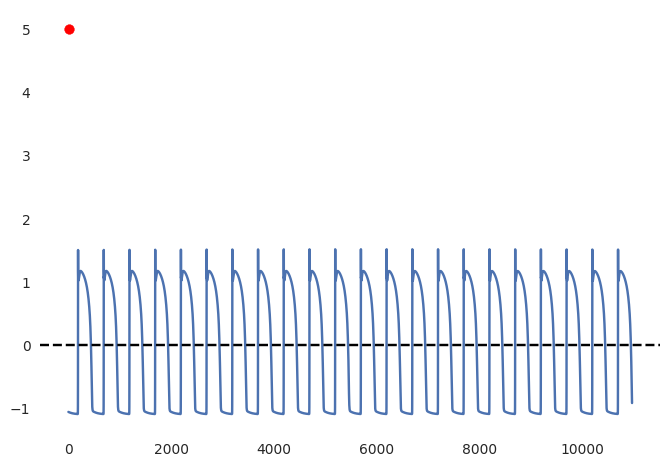

In [251]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(test_data.shape[0]), test_data[:, 0, 0])  # 绘制一些曲线
ax.axhline(y=0, color='black', linestyle='--')  # 绘制时间轴
ax.scatter(x=2, y=5, color='red')  # 在时间轴上的位置 (2, 5) 处绘制一个红色点

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


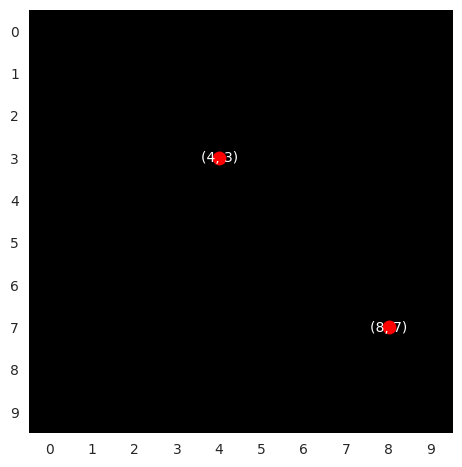

In [243]:
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("white")
# 定义网格的大小
grid_size = 10

# 创建一个大小为 grid_size x grid_size 的零矩阵，用于表示网格
grid = np.ones((grid_size, grid_size))

# 在 (3, 4) 和 (7, 8) 两个坐标上标记点
# grid[3, 4] = 1
# grid[7, 8] = 1

print(grid)
plt.figure()
# 绘制网格和标记点
plt.imshow(grid, cmap="gray")
plt.xticks(range(grid_size))
plt.yticks(range(grid_size))
plt.grid(color='black', linewidth=1)
plt.plot(4, 3, 'ro', markersize=10)  # 绘制红色的圆圈来标记点 (3, 4)
plt.plot(8, 7, 'ro', markersize=10)  # 绘制红色的圆圈来标记点 (7, 8)
plt.text(4, 3, '(4, 3)', color='white', fontsize=10, ha='center', va='center')  # 在点 (3, 4) 处显示坐标
plt.text(8, 7, '(8, 7)', color='white', fontsize=10, ha='center', va='center')  # 在点 (7, 8) 处显示坐标
plt.show()

AttributeError: 'Legend' object has no attribute 'set_anchor'

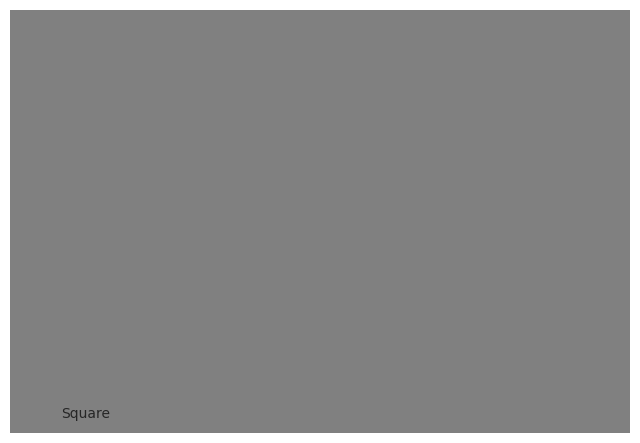

In [38]:
import matplotlib.pyplot as plt

# create a figure with one subplot
fig, ax = plt.subplots()

# create a square
square = plt.Rectangle((0, 0), 1, 1, color='gray')

# add the square to the subplot
ax.add_artist(square)

# set the limits of the subplot
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.autoscale(enable=True, axis='both', tight=None)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.legend([square], ['Square'], loc='lower left')
ax.get_legend().set_anchor((0, 1))


# set the aspect ratio of the subplot to 'equal'
ax.set_aspect('equal')



# show the plot
plt.show()


### 3. tissue square

In [24]:
norm = mcolors.Normalize(vmin=-1.0850763396420926, vmax=3.24444338332082)

In [31]:
import matplotlib.pyplot as plt
import numpy as np

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

def square_LSTM(start):
    plt.figure()
    Vm = proposed_prediction(start)
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(9, 3),
                            subplot_kw={'xticks': [], 'yticks': []})
    rlt = []
    for t, ax in enumerate(axs.flat):
        time_id = t*2
        grid =  Vm[0, time_id, :, 0].reshape(24, 24)
        grid = norm(grid)
#         grid = remap(grid, -1.0850763396420926, 3.24444338332082)
        rlt.append(grid)
        ax.imshow(grid, interpolation='quadric', cmap='coolwarm')  ##coolwarm # tab20c, jet, hsv, coolwarm, bwr, RdYlBu, YlGnBu, Pastel2, Pastel1, Paired
        ax.set_title(f"t={start + time_id}")

    plt.tight_layout()
    plt.savefig('fig_square_pred.png', dpi=500)
    plt.show()
    return np.array(rlt)
    

In [32]:
import matplotlib.pyplot as plt
import numpy as np

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

def square_data(start):
    plt.figure()
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(9, 3),
                            subplot_kw={'xticks': [], 'yticks': []})
    rlt = []
    for t, ax in enumerate(axs.flat):
        time_id = start+t*2
        grid =  test_data[time_id, :, 0].reshape(24, 24)
        grid = norm(grid)
#         grid = remap(grid, -1.0850763396420926, 3.24444338332082)
        rlt.append(grid)
        ax.imshow(grid, interpolation='quadric', cmap='coolwarm')  #nearest quadric
        ax.set_title(f"t={time_id}")

    plt.tight_layout()
    plt.savefig('fig_square_data.png', dpi=500)
    plt.show()
    return np.array(rlt)
#     plt.savefig('fig_square_data.png', dpi=500)

<Figure size 800x550 with 0 Axes>

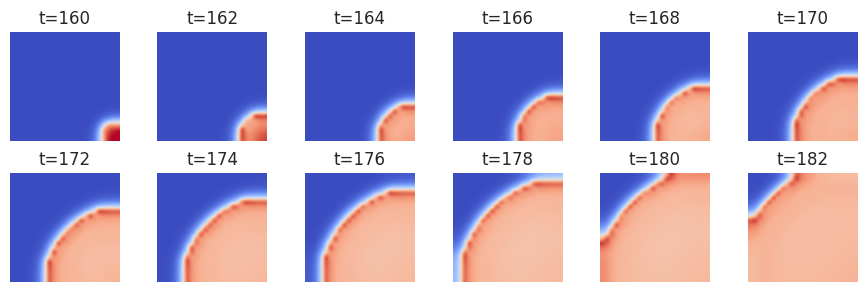

<Figure size 800x550 with 0 Axes>

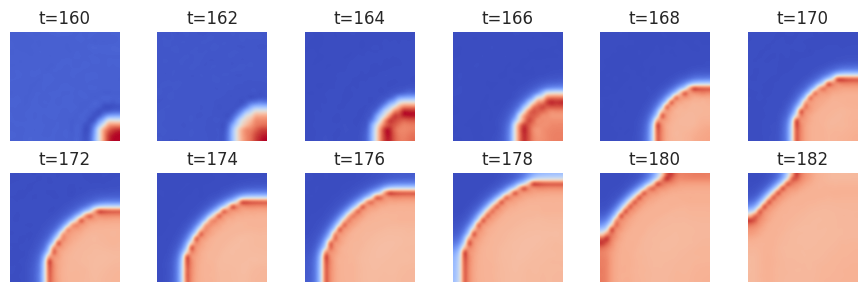

In [33]:
rlt_data0 = square_data(160)
rlt_data1 = square_LSTM(160)
# rlt_data0 = square_data(8)
# rlt_data1 = square_LSTM(8)

In [117]:
rlt_data0[:, 23, 23]

array([-1.07872279, -1.07951382, -1.08022602, -1.0808681 ,  1.27538431,
        1.13567406,  1.14851638,  1.16488419,  1.1677663 ,  1.16398417,
        1.15640508,  1.14600998,  1.1330792 ,  1.11767615,  1.09979164,
        1.07935993,  1.0562398 ,  1.03018979])

In [118]:
rlt_data1[:, 23, 23]

array([-1.0750264 , -1.0331225 , -0.97996604, -0.20252857,  1.2347833 ,
        1.1318663 ,  1.0394591 ,  1.128574  ,  1.1415087 ,  1.1488181 ,
        1.143444  ,  1.1341292 ,  1.1206071 ,  1.1041456 ,  1.0819707 ,
        1.0533117 ,  1.0253049 ,  0.99852806], dtype=float32)

(24, 24) (24, 24)


<Figure size 800x550 with 0 Axes>

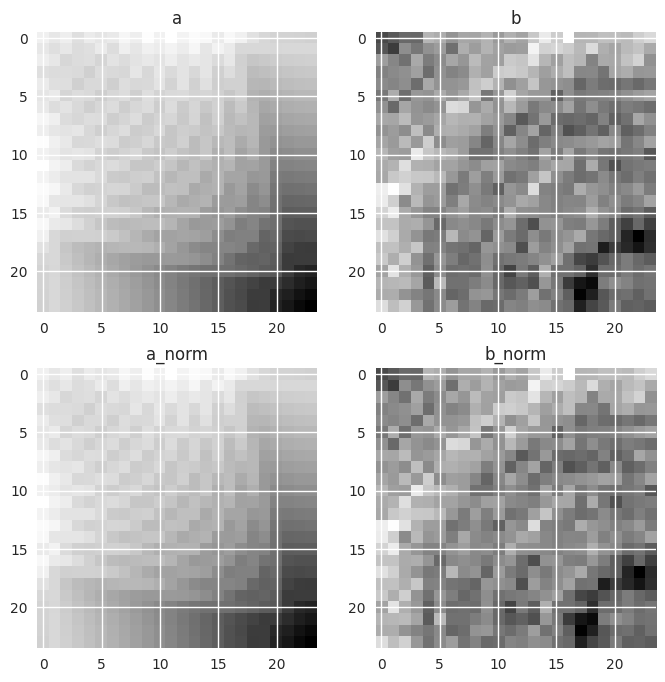

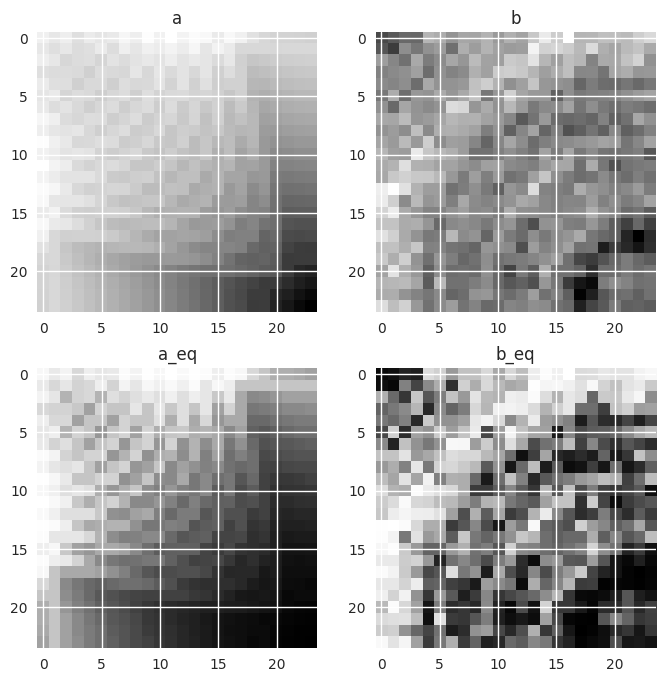

In [120]:


a = rlt_data0[10]
b = rlt_data1[10]

norm = mcolors.Normalize(vmin=np.min([a, b]), vmax=np.max([a, b]))
a_norm = norm(a) 
b_norm = norm(b) 
print(a_norm.shape, b_norm.shape)



# if img.channels() == 3:
#     cvtColor(img, gray, CV_BGR2GRAY)
# elif img.channels() == 4:
#     cvtColor(img, gray, CV_BGRA2GRAY)
# else:  
#     gray = img
# a_gray = cv2.cvtColor((a_norm*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
# a_eq = cv2.equalizeHist(a_norm.astype(np.uint8))
# b_eq = cv2.equalizeHist(b_norm.astype(np.uint8))

a_eq = cv2.equalizeHist((a_norm*255).astype(np.uint8))/255.0
b_eq = cv2.equalizeHist((b_norm*255).astype(np.uint8))/255.0

plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(a, cmap='gray')
axs[0, 0].set_title('a')
axs[0, 1].imshow(b, cmap='gray')
axs[0, 1].set_title('b')
axs[1, 0].imshow(a_norm, cmap='gray')
axs[1, 0].set_title('a_norm')
axs[1, 1].imshow(b_norm, cmap='gray')
axs[1, 1].set_title('b_norm')
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(a, interpolation='nearest', cmap='gray')
axs[0, 0].set_title('a')
axs[0, 1].imshow(b, interpolation='nearest', cmap='gray')
axs[0, 1].set_title('b')
axs[1, 0].imshow(a_eq, interpolation='nearest', cmap='gray')
axs[1, 0].set_title('a_eq')
axs[1, 1].imshow(b_eq, interpolation='nearest', cmap='gray')
axs[1, 1].set_title('b_eq')
plt.show()

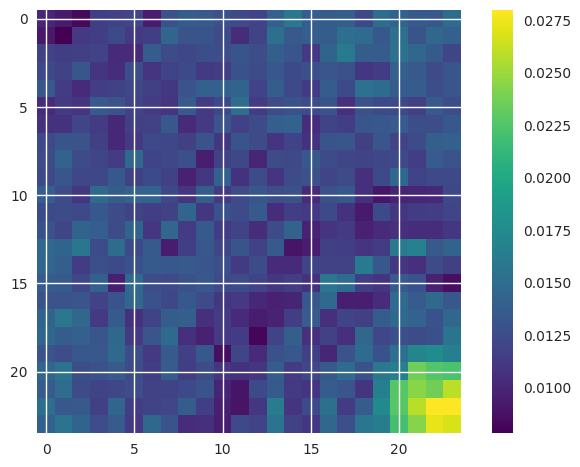

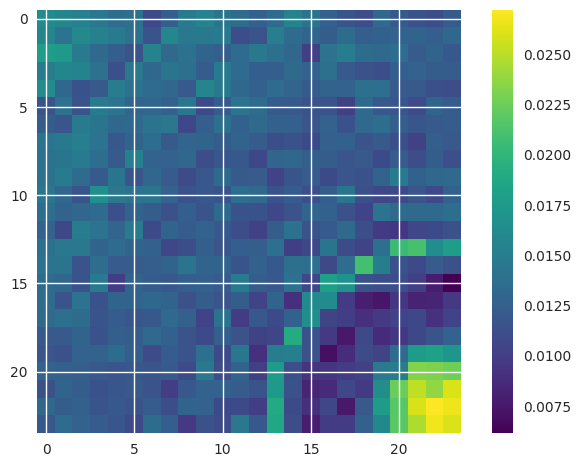

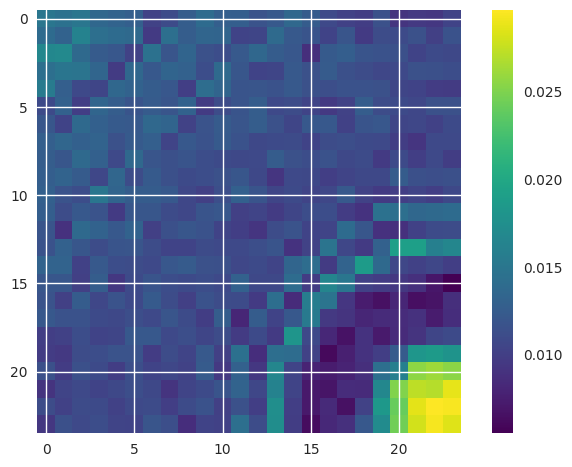

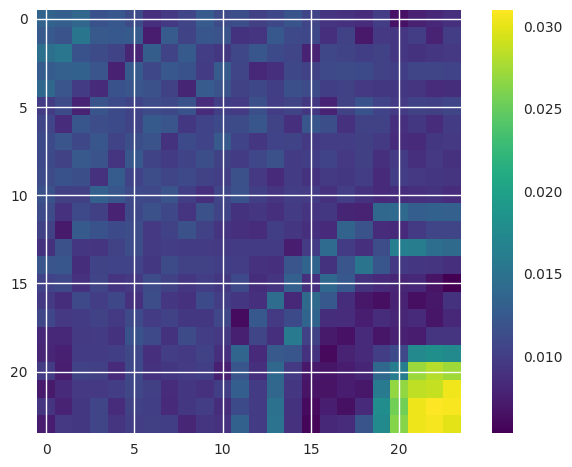

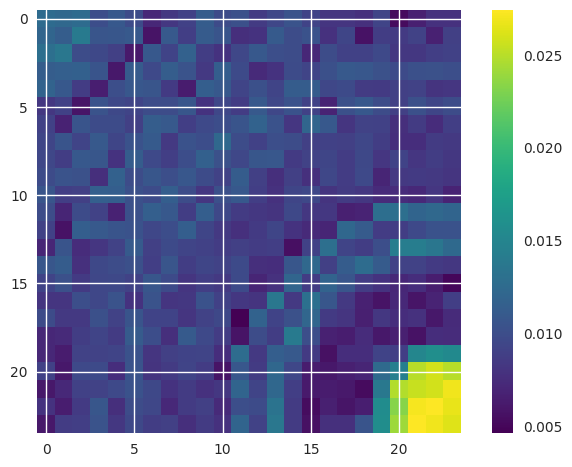

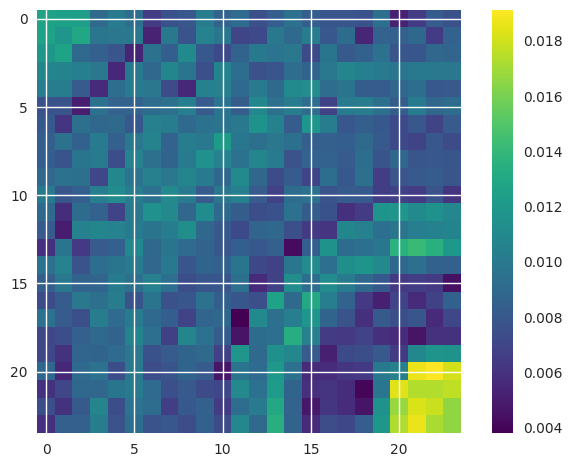

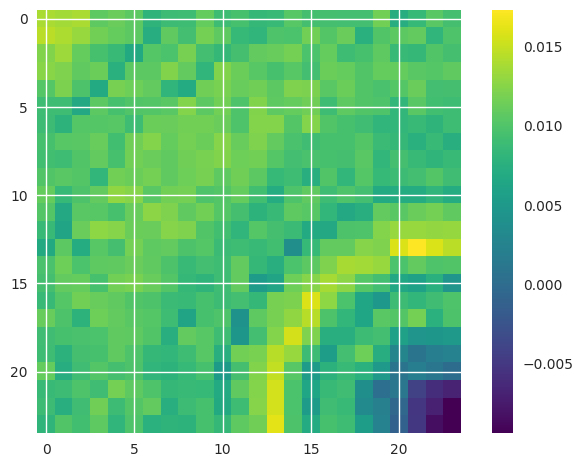

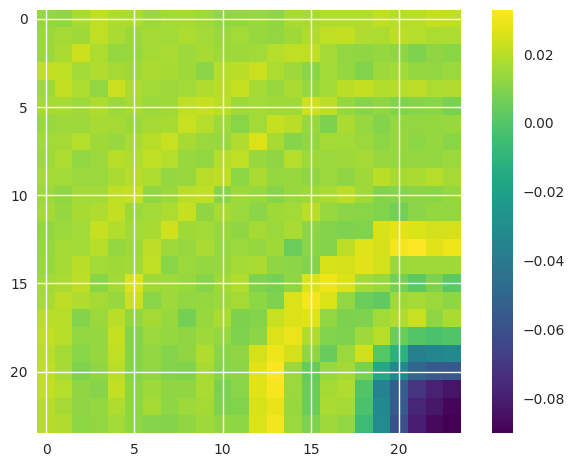

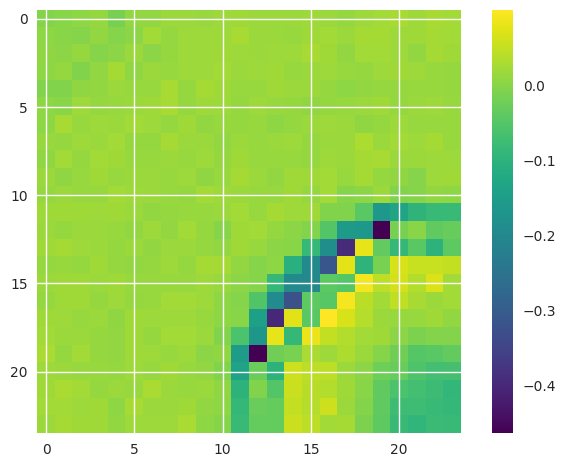

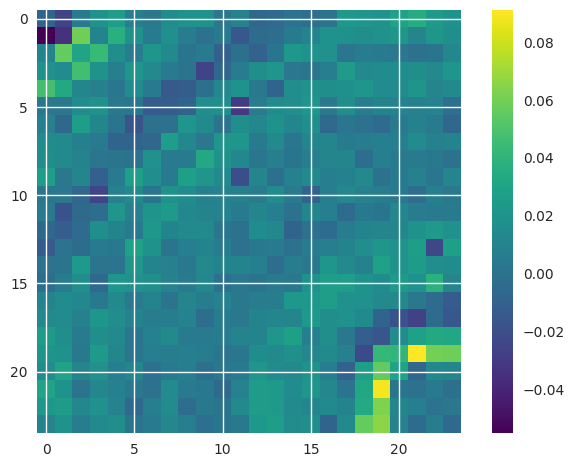

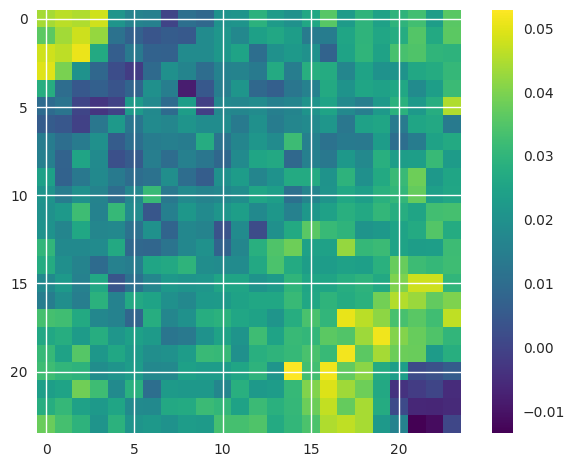

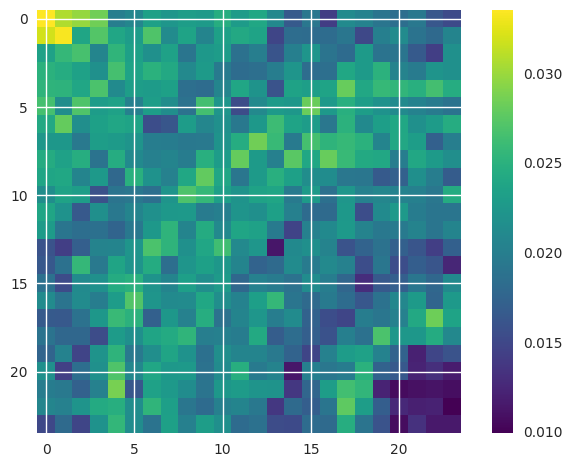

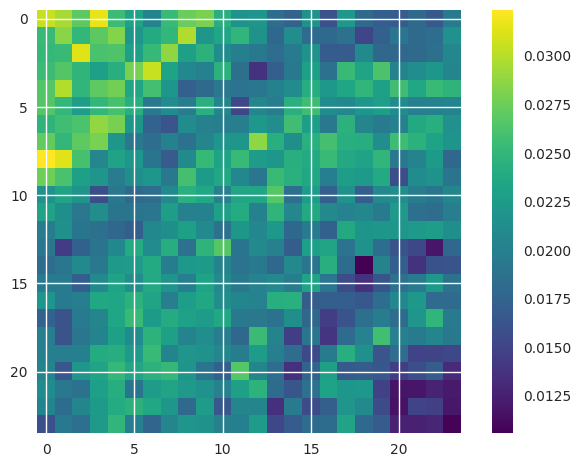

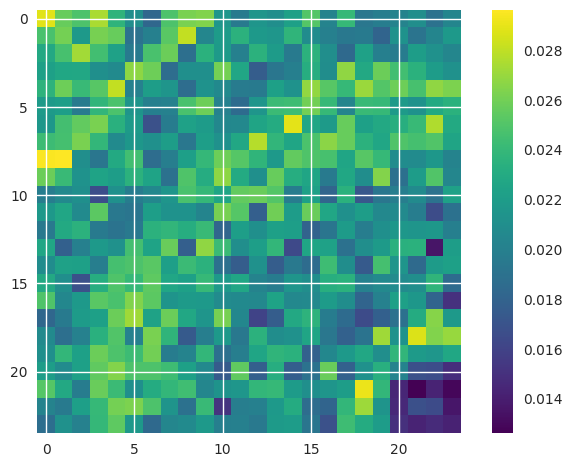

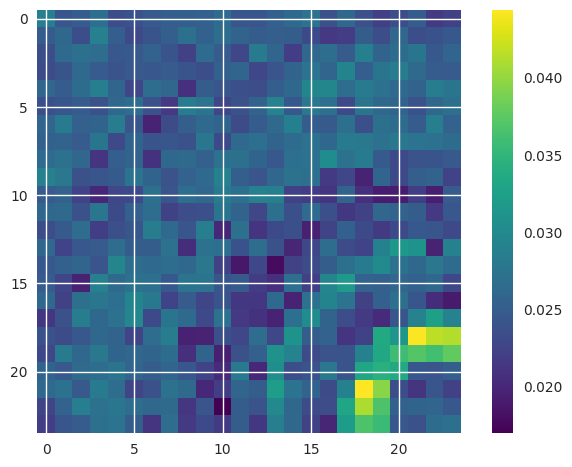

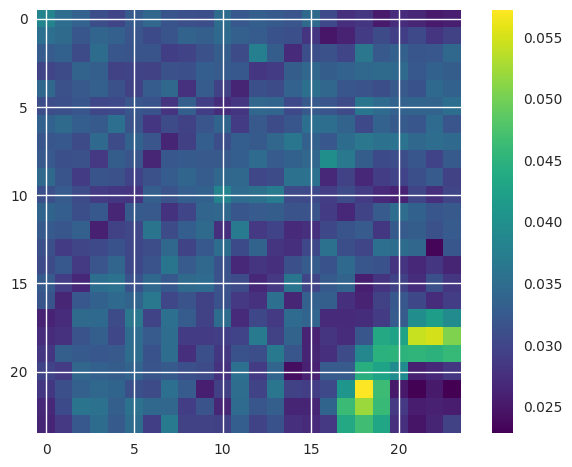

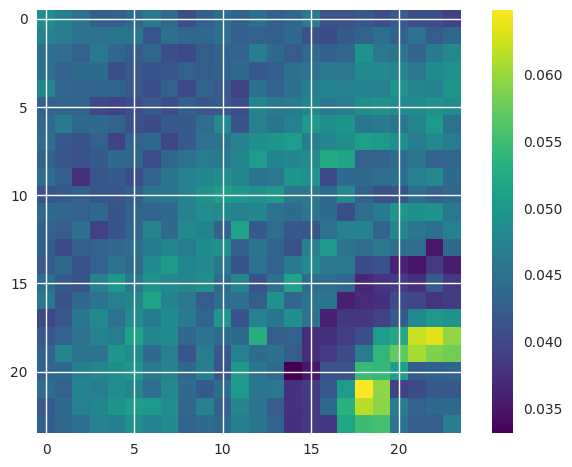

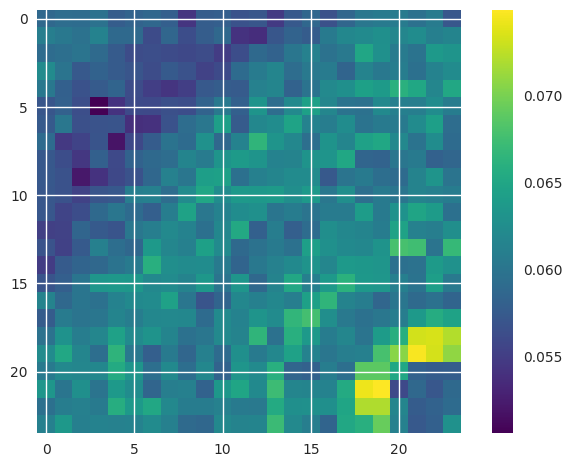

In [55]:
for i in range(18):
    plt.figure()
    plt.imshow(rlt_data0[i]-rlt_data1[i], cmap="viridis")
    plt.colorbar()
    plt.show()

In [32]:
rlt_data0[0]

array([[-1.0544449 , -1.05442906, -1.05459181, -1.05456502, -1.05473651,
        -1.05485805, -1.05489114, -1.05508048, -1.0550816 , -1.05532428,
        -1.05534749, -1.05558597, -1.05560564, -1.05582102, -1.05587812,
        -1.05590754, -1.05605164, -1.05601757, -1.05596977, -1.05595923,
        -1.05599748, -1.05604328, -1.05606344, -1.05607811],
       [-1.05442906, -1.05446907, -1.05456526, -1.05461409, -1.05465844,
        -1.05486843, -1.05484973, -1.05504381, -1.05512687, -1.05529163,
        -1.05541294, -1.05556065, -1.05564862, -1.05582319, -1.05580094,
        -1.05598469, -1.05600642, -1.05593752, -1.05595863, -1.05599073,
        -1.05605176, -1.05610996, -1.05613625, -1.05615442],
       [-1.05459181, -1.05456526, -1.05454451, -1.05462464, -1.05476898,
        -1.05476705, -1.05493537, -1.05502504, -1.05512674, -1.05532894,
        -1.05538198, -1.05560471, -1.05563913, -1.05583102, -1.05587842,
        -1.05593419, -1.05608151, -1.05596447, -1.05594712, -1.05599029,
  

In [33]:
rlt_data1[0]

array([[-1.064412 , -1.0637115, -1.0628489, -1.0661342, -1.0664209,
        -1.0668803, -1.0643574, -1.0679415, -1.0688689, -1.0687889,
        -1.0681745, -1.0678668, -1.067503 , -1.069825 , -1.0718056,
        -1.0697346, -1.0698435, -1.0699812, -1.0681376, -1.0708702,
        -1.0703493, -1.0695498, -1.0693746, -1.0710415],
       [-1.0636512, -1.0622919, -1.0657336, -1.066183 , -1.0669711,
        -1.066026 , -1.0664428, -1.0694637, -1.0681226, -1.0683421,
        -1.067895 , -1.0660503, -1.0676141, -1.0711135, -1.0692657,
        -1.0697988, -1.0697734, -1.0710928, -1.0707988, -1.0693817,
        -1.0713428, -1.0692034, -1.0706085, -1.0701807],
       [-1.0662991, -1.0661201, -1.0661983, -1.066478 , -1.0649918,
        -1.0650116, -1.0686316, -1.0675569, -1.0673509, -1.0679617,
        -1.0679932, -1.0686883, -1.0682443, -1.0697876, -1.0691044,
        -1.0671908, -1.0704136, -1.0721616, -1.0697358, -1.0697008,
        -1.0713664, -1.070668 , -1.0697141, -1.0681717],
       [-1.06

In [48]:
np.mean(rlt_data1[0])

-1.069501

In [49]:
np.mean(rlt_data0[0])

-1.0567081735363013

In [29]:
np.sum(np.abs(rlt_data0-rlt_data1))

946.4205553576887

In [ ]:
min_error = 10000000
for i in range(1, 500):
    print("*"*100)
    rlt_data0 = square_data(i)
    rlt_data1 = square_LSTM(i)
    error = np.mean(np.abs(rlt_data0-rlt_data1))
    if error < min_error:
        print(i, error)
        min_error = error

****************************************************************************************************
1 0.040591653883448243
****************************************************************************************************
2 0.03578629025651232
****************************************************************************************************
3 0.027281308830516653
****************************************************************************************************
4 0.025842820733915882
****************************************************************************************************
5 0.02573135640206711
****************************************************************************************************


/tmp/ipykernel_21935/3538015971.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


6 0.025338132365244296
****************************************************************************************************
7 0.021901752264551808
****************************************************************************************************
8 0.021458666440054532
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
**********************

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
*******************************************************************************************

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
*******************************************************************************************

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
*******************************************************************************************

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
*******************************************************************************************

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
*******************************************************************************************

****************************************************************************************************
****************************************************************************************************
****************************************************************************************************
